In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

from antarctic_plots import utils, regions, maps, fetch, profile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import harmonica as hm
import pvxarray
import pyvista as pv
import numpy.testing as npt

begin [ERROR]: Failed to remove gmt_11.ps-! [remove error: Permission denied]
begin [WARNING]: Unable to remove gmt_11.ps- [permissions?]
PROJ: proj_create_from_database: Cannot find proj.db


# Set region and spacing

In [90]:
spacing = 10e3
region = [-10e3, 10e3, -10e3, 10e3]
outer_region = utils.alter_region(region, zoom=-spacing)[0]

# Create grids 

## Gridline

In [91]:
# create tuple of coordinates
coords_g = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
)

# create grid from spacing and coordinates
coords = coords_g
surface_g = vd.make_xarray_grid(
    coords, 
    data = np.reshape(np.linspace(100,1000,np.size(coords[0])), np.shape(coords[0])),
    data_names="z", dims=("y", "x"),
).z

## Pixel

In [92]:
# create tuple of coordinates
coords_p = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=True,
)

# create grid from spacing and coordinates
coords = coords_p
surface_p = vd.make_xarray_grid(
    coords, 
    data = np.reshape(np.linspace(100,1000,np.size(coords[0])), np.shape(coords[0])),
    data_names="z", dims=("y", "x"),
).z

## Compare

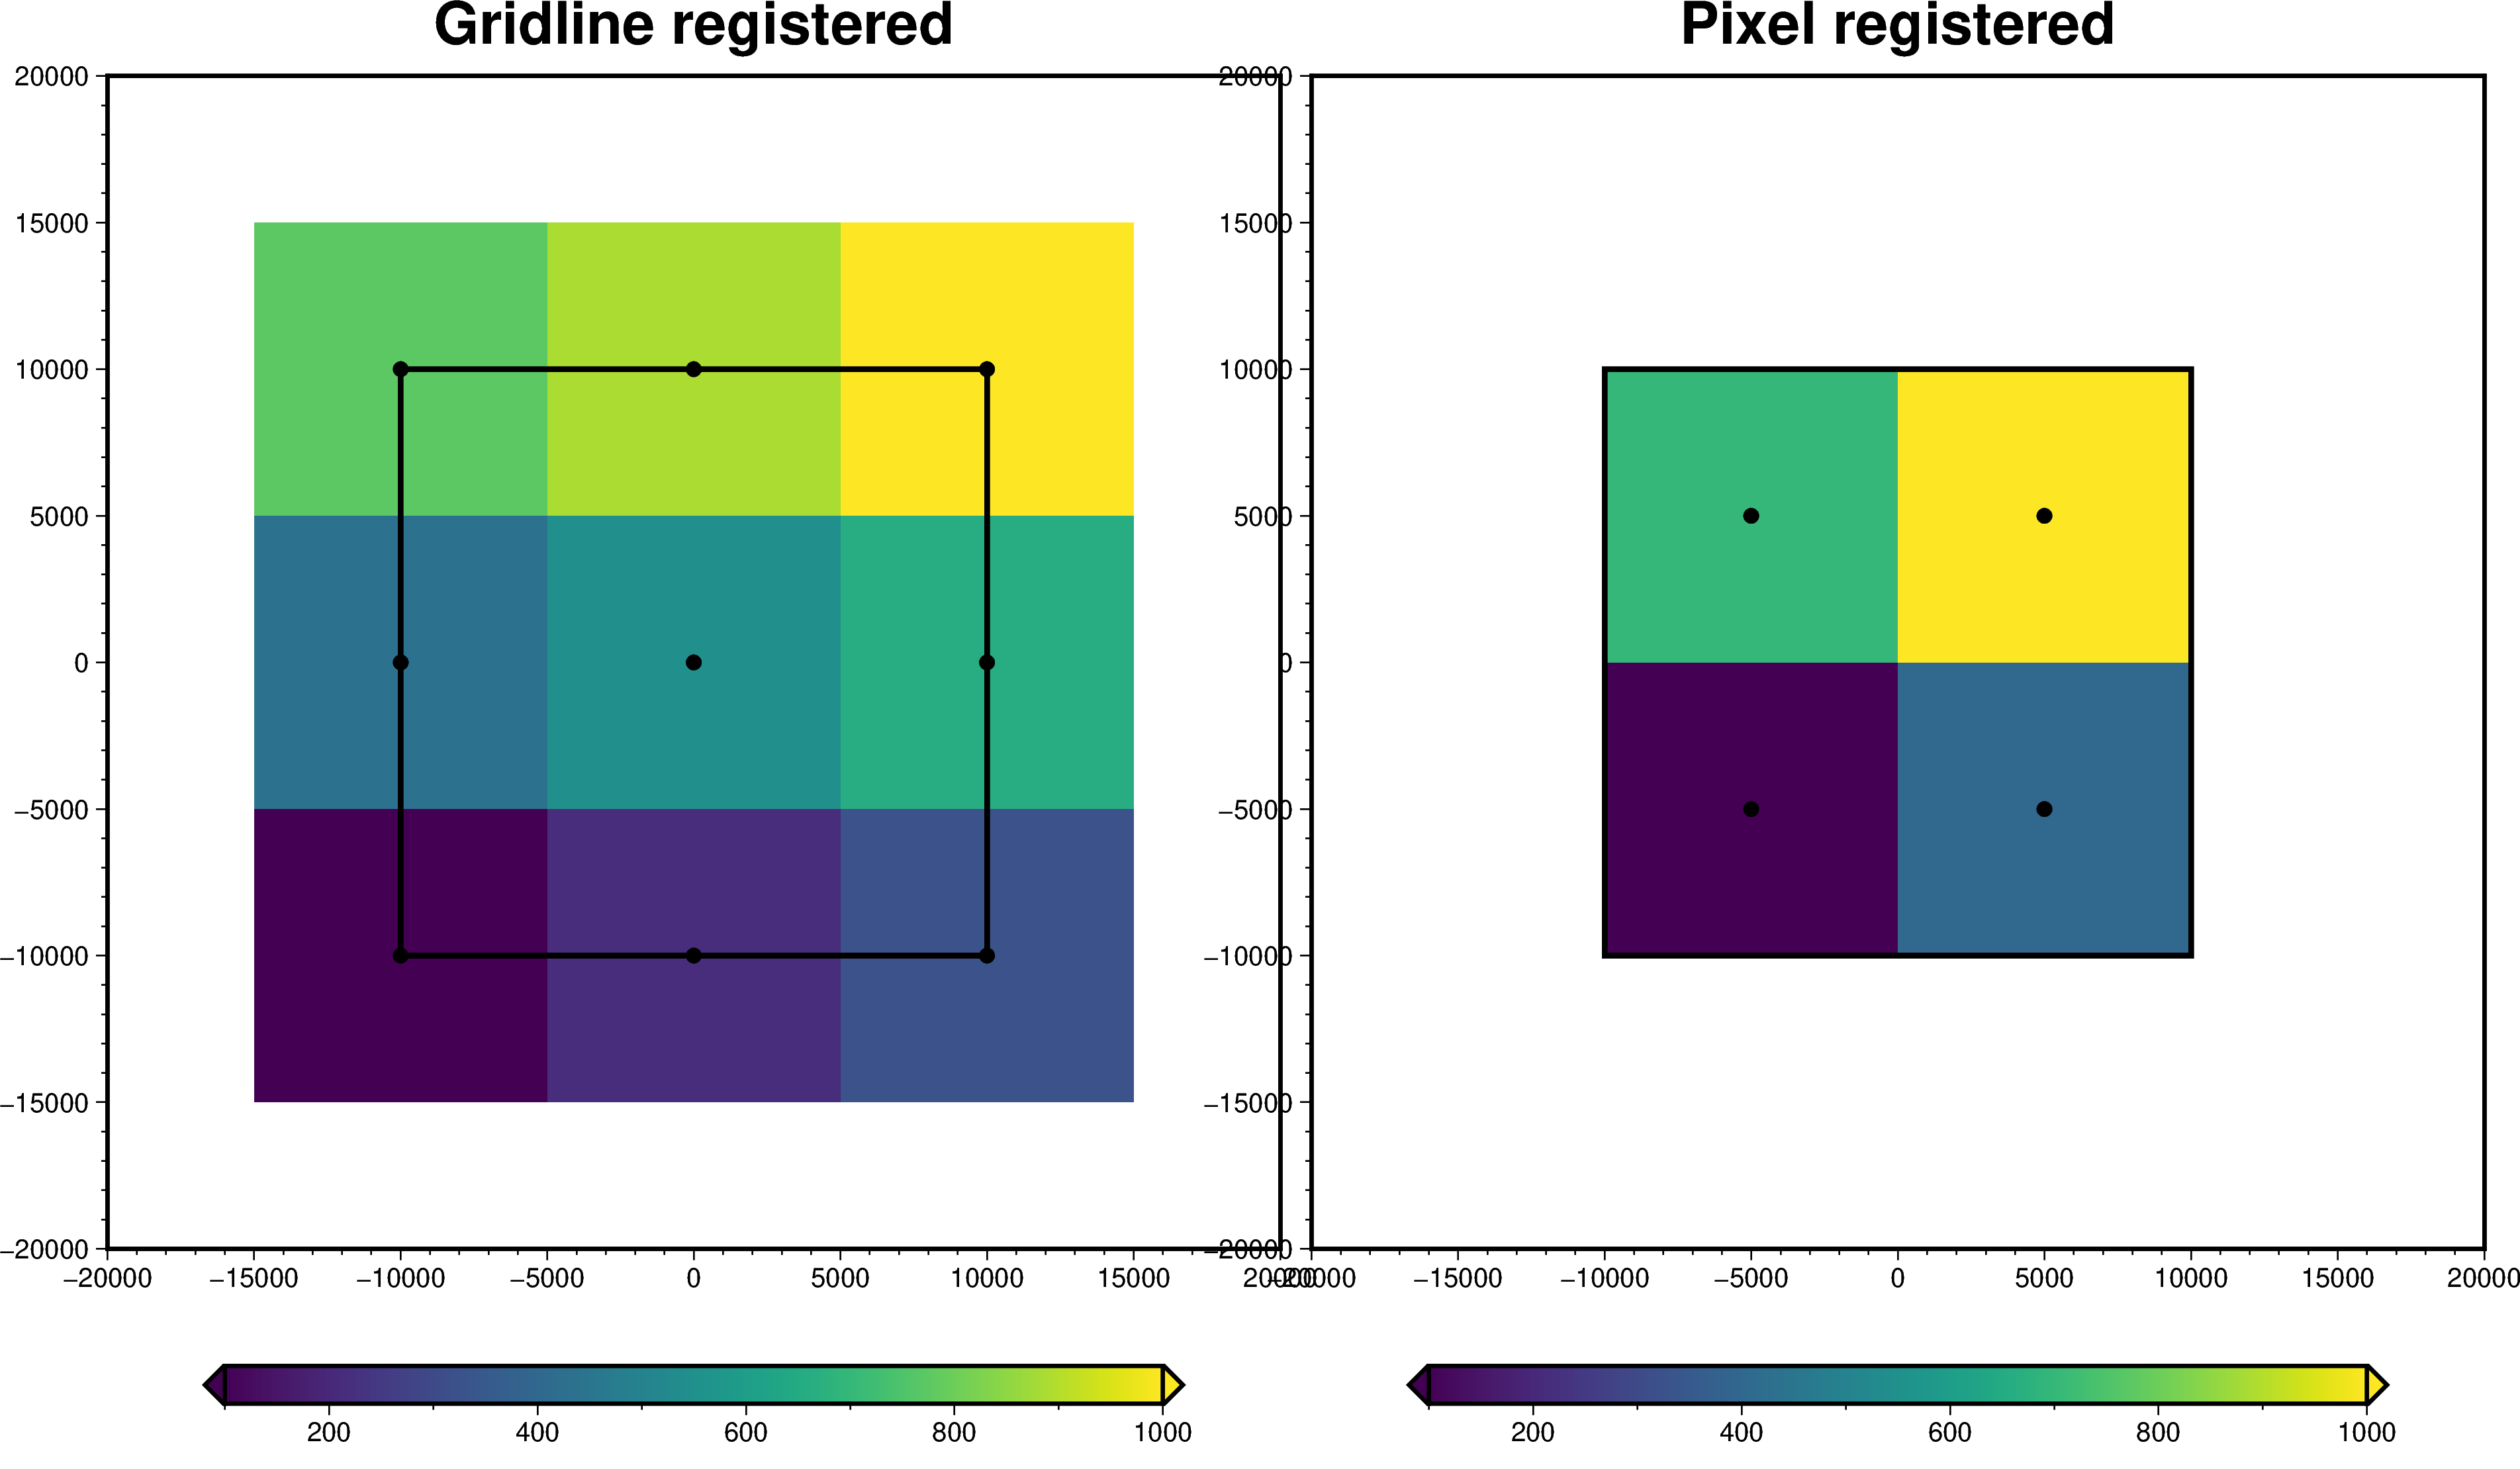

In [93]:
fig = maps.plot_grd(
    surface_g,
    region=outer_region,
    points=vd.grid_to_table(surface_g),
    frame=True,
    cbar_yoffset=1.5,
    title='Gridline registered',
    show_region=region, 
)

fig = maps.plot_grd(
    surface_p,
    region=outer_region,
    points=vd.grid_to_table(surface_p),
    frame=True,
    cbar_yoffset=1.5,
    fig=fig,
    origin_shift="xshift",
    title='Pixel registered',
    show_region=region, 
)

fig.show()

# High-res version

In [94]:
# create prisms at half spacing
def repeated_grid(grid):
    a = [[element for item in sublist for element in (item, item)] for sublist in grid.values]
    repeated = [val for val in a for _ in (0, 1)]
    return np.array(repeated)

## Gridline

In [95]:
coords_g_highres = vd.grid_coordinates(
    region=utils.alter_region(region, zoom=-spacing/4)[0],
    spacing=spacing/2,
    pixel_register=False,
)

# duplicate the prisms     
shp = np.shape(coords_g_highres[0])
data = repeated_grid(surface_g)
data = data[0:shp[0], 0:shp[1]]

surface_g_highres = vd.make_xarray_grid(
    coords_g_highres, 
    data = data,
    data_names="z", dims=("y", "x"),
).z

## Pixel

In [96]:
coords_p_highres = vd.grid_coordinates(
    region=region,
    spacing=spacing/2,
    pixel_register=True,
)

# duplicate the prisms      
shp = np.shape(coords_p_highres[0])
data = repeated_grid(surface_p)
data = data[0:shp[0], 0:shp[1]]

surface_p_highres = vd.make_xarray_grid(
    coords_p_highres, 
    data = data,
    data_names="z", dims=("y", "x"),
).z

## Compare

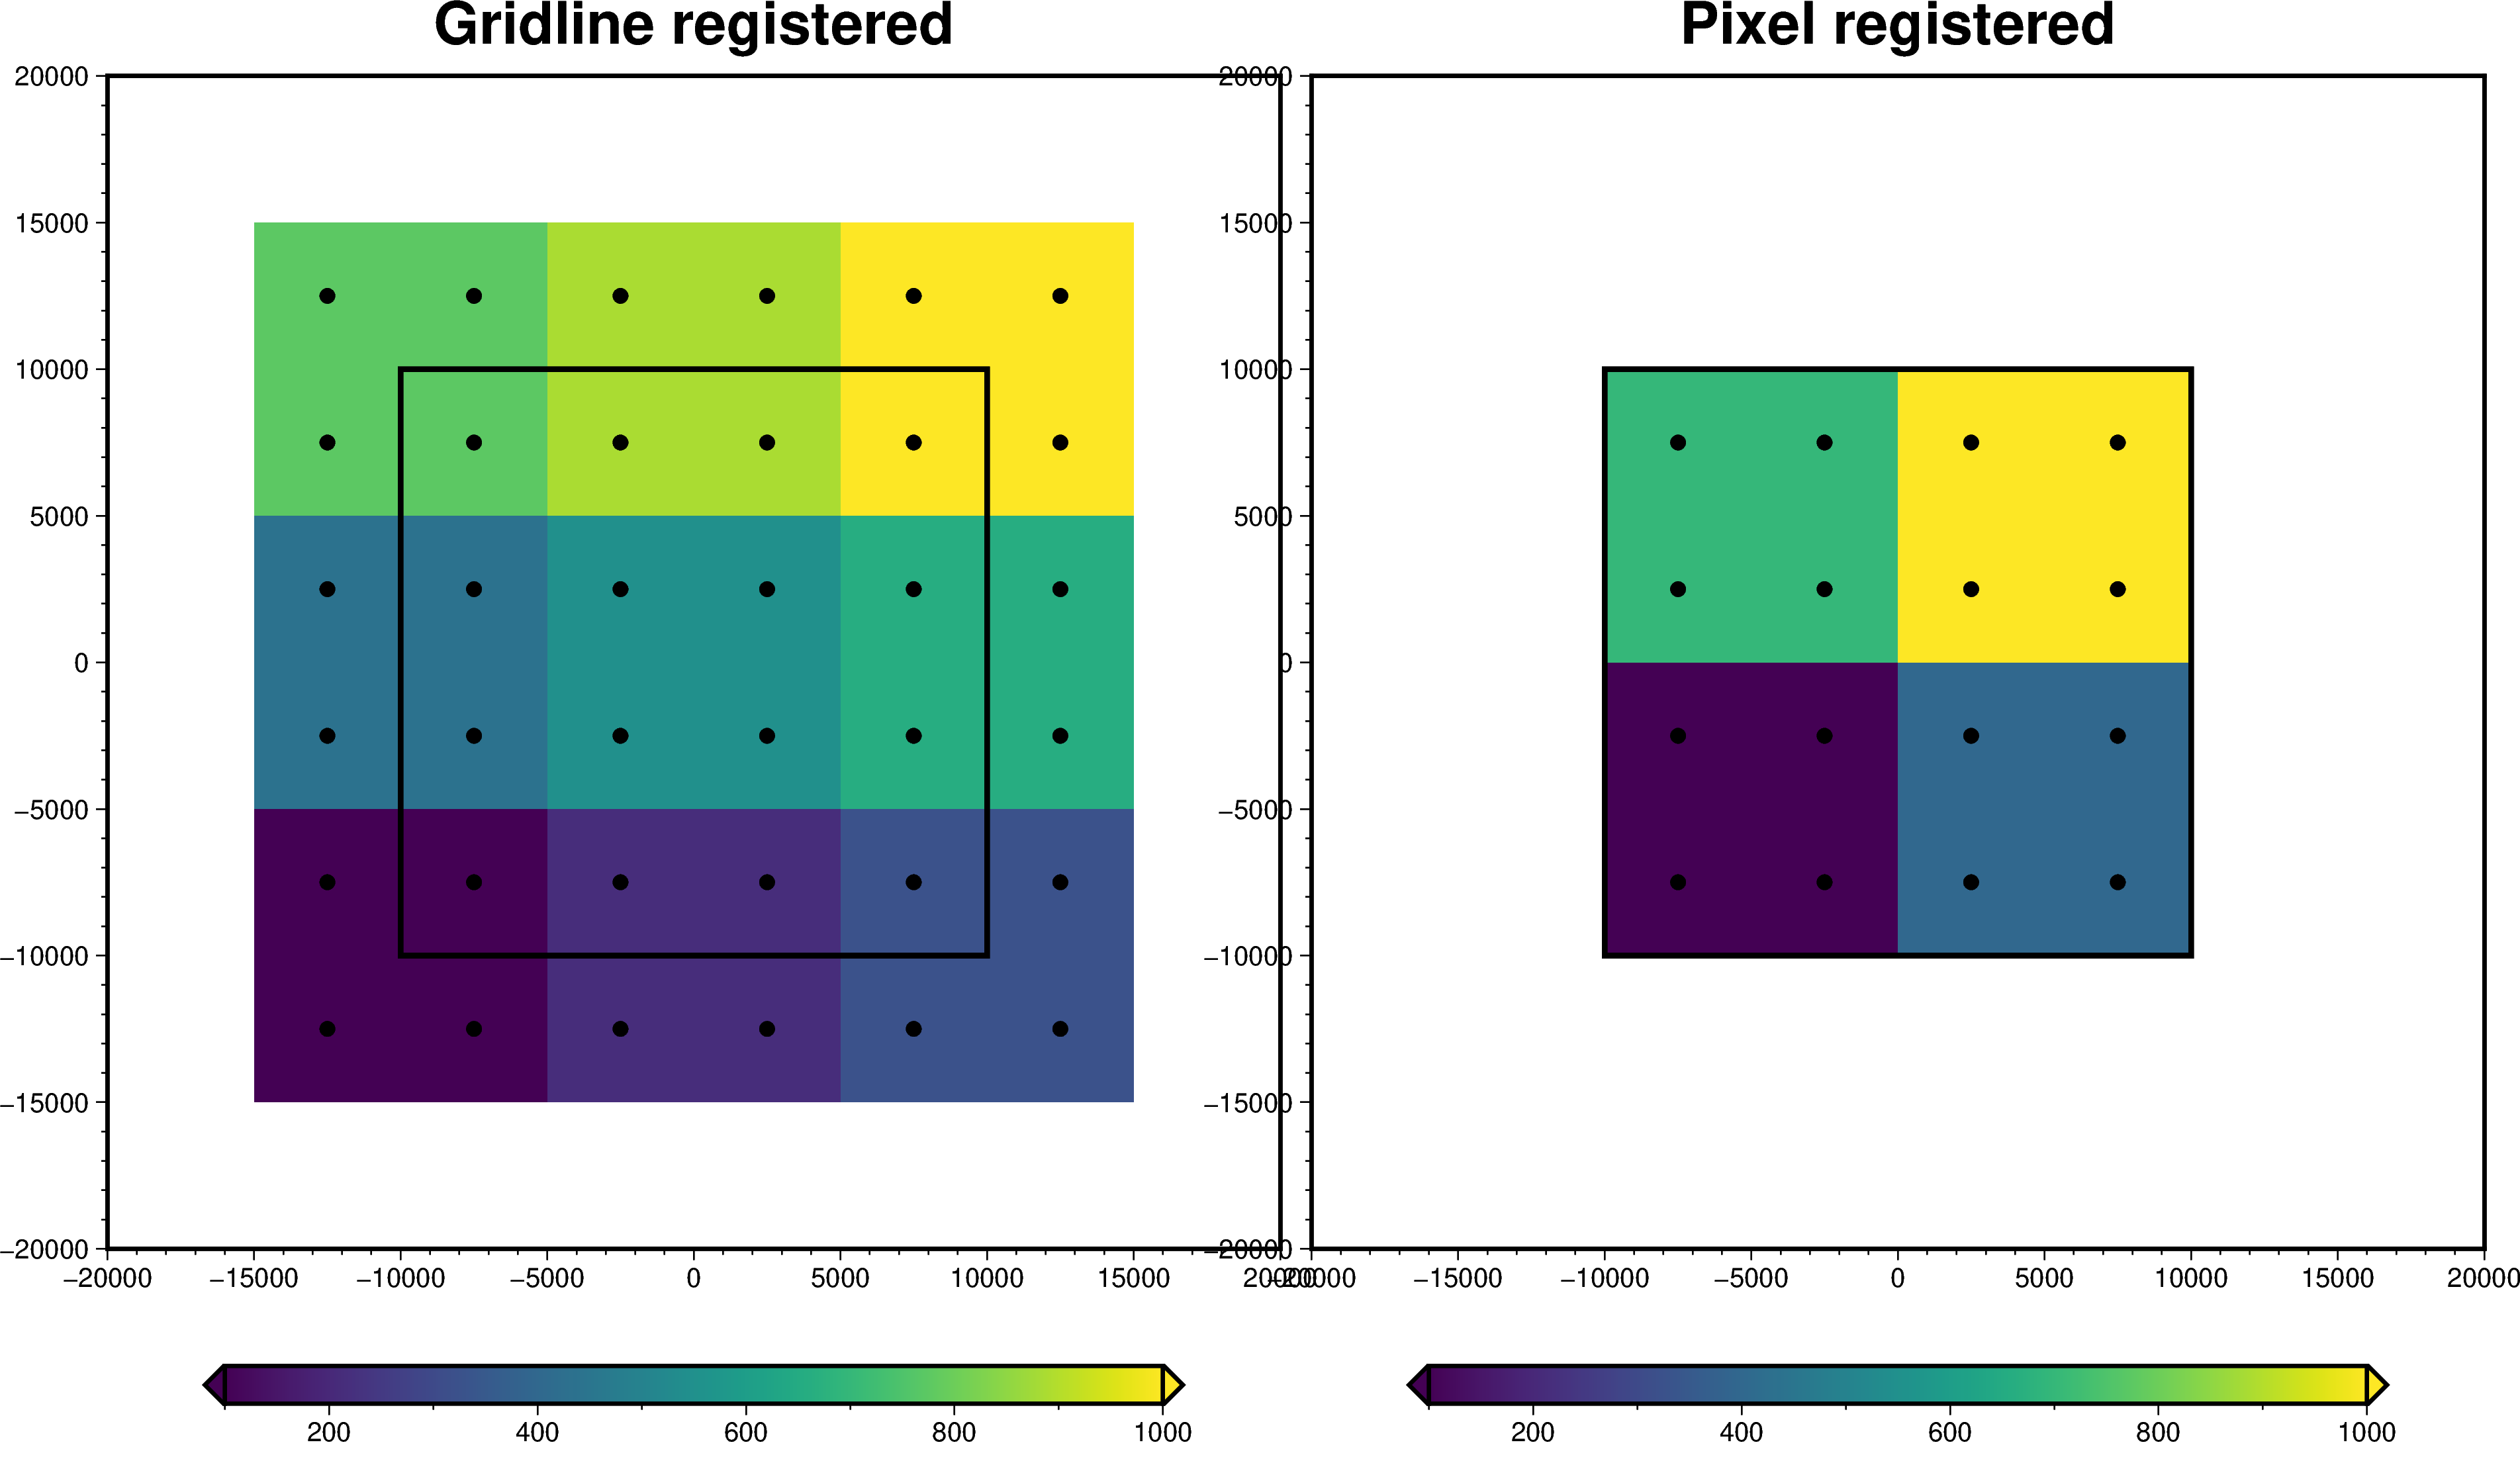

In [98]:
fig = maps.plot_grd(
    surface_g_highres,
    region=outer_region,
    points=vd.grid_to_table(surface_g_highres),
    frame=True,
    cbar_yoffset=1.5,
    title='Gridline registered',
    show_region=region, 
)

fig = maps.plot_grd(
    surface_p_highres,
    region=outer_region,
    points=vd.grid_to_table(surface_p_highres),
    frame=True,
    cbar_yoffset=1.5,
    fig=fig,
    origin_shift="xshift",
    title='Pixel registered',
    show_region=region, 
)

fig.show()

# Create prism layers

## Gridline

c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\pyvista\core\pointset.py:262: PyVistaDeprecationWarning: You did not specify a value for `inplace` and the default value will be changing to `False` in future versions for point-based meshes (e.g., `PolyData`). Please make sure you are not assuming this to be an inplace operation.
  warnings.warn(DEFAULT_INPLACE_WARNING, PyVistaDeprecationWarning)


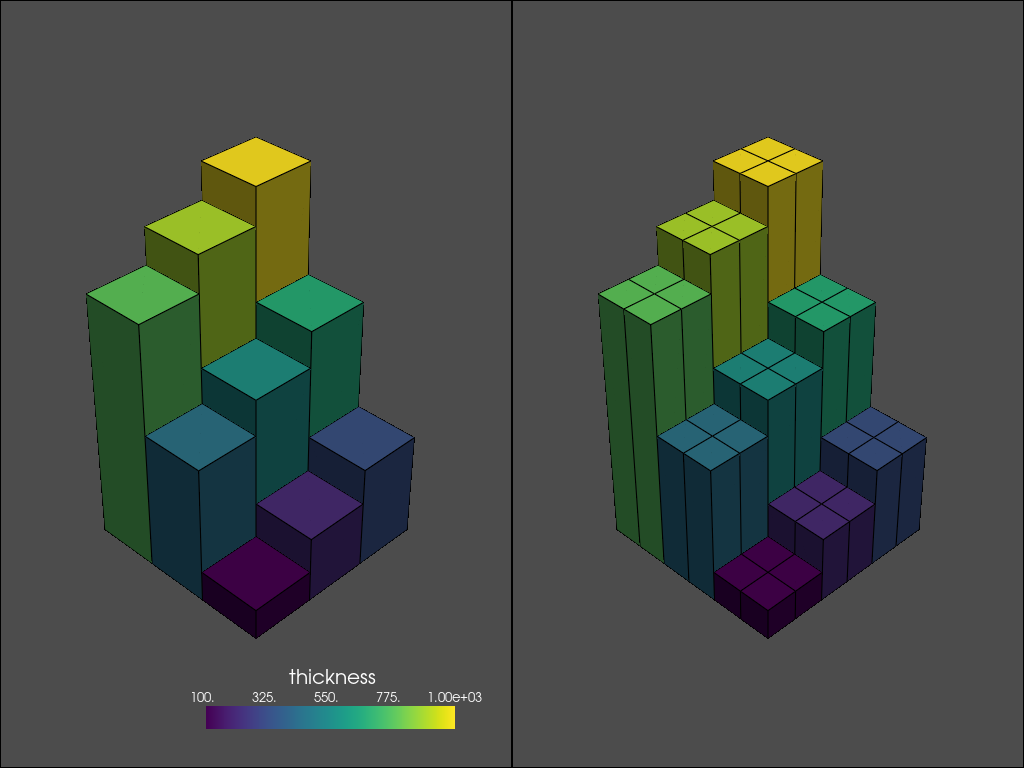

In [99]:
# create prisms from grid
bottom = np.zeros_like(surface_g)
bottom_highres = np.zeros_like(surface_g_highres)

prisms_g = hm.prism_layer(
    coordinates=(surface_g.x.values, surface_g.y.values),
    surface=surface_g,
    reference=bottom,
    properties={
        "density": 2670*np.ones_like(surface_g),
        "thickness": surface_g - bottom,
    },
)
prisms_g_highres = hm.prism_layer(
    coordinates=(surface_g_highres.x.values, surface_g_highres.y.values),
    surface=surface_g_highres,
    reference=bottom_highres,
    properties={
        "density": 2670*np.ones_like(surface_g_highres),
        "thickness": surface_g_highres - bottom_highres,
    },
)

pl = pv.Plotter(shape=(1,2))

# prisms
pl.add_mesh(prisms_g.prism_layer.to_pyvista().scale([1,1,50]),
    show_edges=True, 
)

# high res prisms
pl.subplot(0,1)
pl.add_mesh(prisms_g_highres.prism_layer.to_pyvista().scale([1,1,50]),
    show_edges=True, 
)

pl.show( 
    cpos=[-10,-10,10],
    jupyter_backend='static',
)

## Pixel

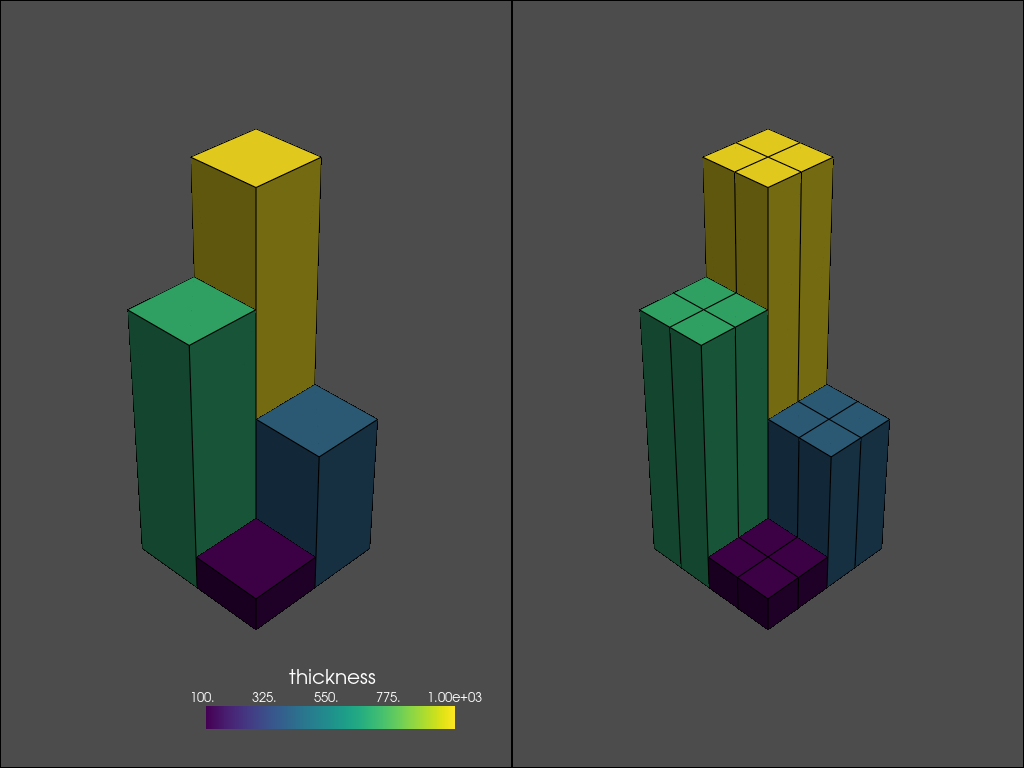

In [100]:
# create prisms from grid
bottom = np.zeros_like(surface_p)
bottom_highres = np.zeros_like(surface_p_highres)

prisms_p = hm.prism_layer(
    coordinates=(surface_p.x.values, surface_p.y.values),
    surface=surface_p,
    reference=bottom,
    properties={
        "density": 2670*np.ones_like(surface_p),
        "thickness": surface_p - bottom,
    },
)
prisms_p_highres = hm.prism_layer(
    coordinates=(surface_p_highres.x.values, surface_p_highres.y.values),
    surface=surface_p_highres,
    reference=bottom_highres,
    properties={
        "density": 2670*np.ones_like(surface_p_highres),
        "thickness": surface_p_highres - bottom_highres,
    },
)

pl = pv.Plotter(shape=(1,2))

# prisms
pl.add_mesh(prisms_p.prism_layer.to_pyvista().scale([1,1,50]),
    show_edges=True, 
)

# high res prisms
pl.subplot(0,1)
pl.add_mesh(prisms_p_highres.prism_layer.to_pyvista().scale([1,1,50]),
    show_edges=True, 
)

pl.show( 
    cpos=[-10,-10,10],
    jupyter_backend='static',
)

# Forward gravity 

In [101]:
observation_points = vd.grid_coordinates(
    region,
    spacing=spacing/2,
    extra_coords=1.2e3,
)
observation_points

(array([[-10000.,  -5000.,      0.,   5000.,  10000.],
        [-10000.,  -5000.,      0.,   5000.,  10000.],
        [-10000.,  -5000.,      0.,   5000.,  10000.],
        [-10000.,  -5000.,      0.,   5000.,  10000.],
        [-10000.,  -5000.,      0.,   5000.,  10000.]]),
 array([[-10000., -10000., -10000., -10000., -10000.],
        [ -5000.,  -5000.,  -5000.,  -5000.,  -5000.],
        [     0.,      0.,      0.,      0.,      0.],
        [  5000.,   5000.,   5000.,   5000.,   5000.],
        [ 10000.,  10000.,  10000.,  10000.,  10000.]]),
 array([[1200., 1200., 1200., 1200., 1200.],
        [1200., 1200., 1200., 1200., 1200.],
        [1200., 1200., 1200., 1200., 1200.],
        [1200., 1200., 1200., 1200., 1200.],
        [1200., 1200., 1200., 1200., 1200.]]))

## Gridline

In [102]:
grav_g = prisms_g.prism_layer.gravity(
    coordinates=observation_points,
    field="g_z",
    progressbar=True,
)

grav_grid_g = vd.make_xarray_grid(
    coordinates=observation_points,
    data=grav_g,
    data_names="grav",
    extra_coords_names="height",
).grav

#high res
grav_g_highres = prisms_g_highres.prism_layer.gravity(
    coordinates=observation_points,
    field="g_z",
    progressbar=True,
)

grav_grid_g_highres = vd.make_xarray_grid(
    coordinates=observation_points,
    data=grav_g_highres,
    data_names="grav",
    extra_coords_names="height",
).grav

npt.assert_allclose(grav_g, grav_g_highres)
npt.assert_array_almost_equal(grav_g, grav_g_highres, decimal=12)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

AssertionError: 
Arrays are not almost equal to 12 decimals

Mismatched elements: 6 / 25 (24%)
Max absolute difference: 1.69109171e-12
Max relative difference: 1.38470559e-13
 x: array([[ 11.481425254252,  17.234887538238,  22.772575422073,
         28.166636200993,  32.565582955303],
       [ 28.047147597659,  34.460673942999,  40.343813113396,...
 y: array([[ 11.481425254254,  17.234887538236,  22.772575422073,
         28.166636200995,  32.565582955303],
       [ 28.047147597659,  34.460673942998,  40.343813113396,...

returning original grid
returning original grid


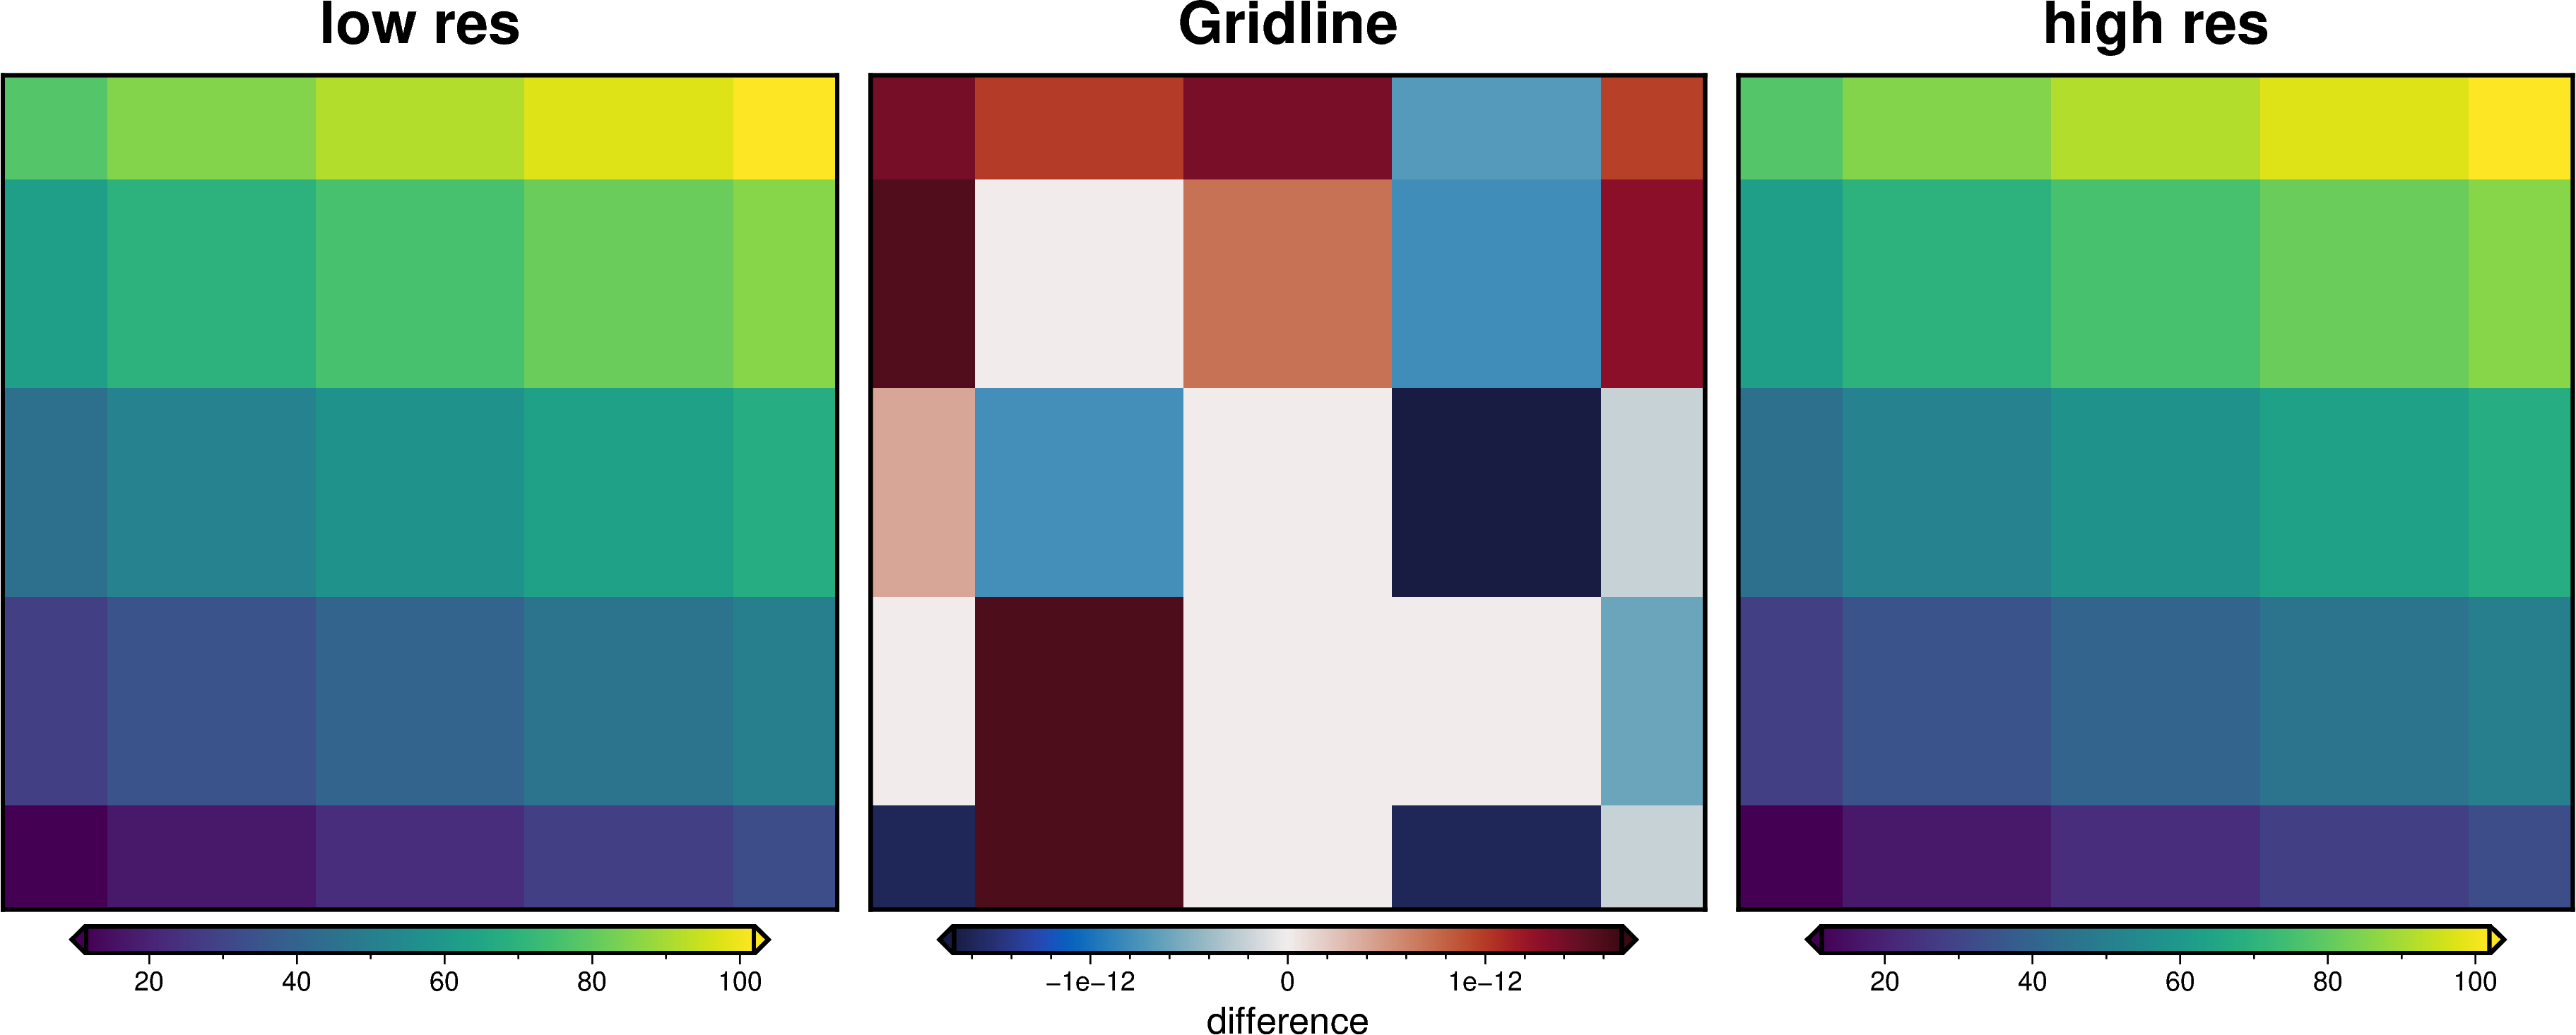

In [103]:
grids = utils.grd_compare(
    grav_grid_g, 
    grav_grid_g_highres, 
    plot=True,
    inset=False,
    grid1_name="low res",
    grid2_name="high res",
    title='Gridline',
    )

## Pixel

In [104]:
grav_p = prisms_p.prism_layer.gravity(
    coordinates=observation_points,
    field="g_z",
    progressbar=True,
)

grav_grid_p = vd.make_xarray_grid(
    coordinates=observation_points,
    data=grav_p,
    data_names="grav",
    extra_coords_names="height",
).grav

#high res
grav_p_highres = prisms_p_highres.prism_layer.gravity(
    coordinates=observation_points,
    field="g_z",
    progressbar=True,
)

grav_grid_p_highres = vd.make_xarray_grid(
    coordinates=observation_points,
    data=grav_p_highres,
    data_names="grav",
    extra_coords_names="height",
).grav

npt.assert_allclose(grav_p, grav_p_highres)
npt.assert_array_almost_equal(grav_p, grav_p_highres, decimal=12)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

AssertionError: 
Arrays are not almost equal to 12 decimals

Mismatched elements: 1 / 25 (4%)
Max absolute difference: 1.5845103e-12
Max relative difference: 1.27157816e-13
 x: array([[  3.17443232684 ,   6.02362144782 ,  13.380775570266,
         20.085802456432,  10.739684757468],
       [  6.258426630496,  11.966210042966,  26.282093462908,...
 y: array([[  3.17443232684 ,   6.02362144782 ,  13.380775570265,
         20.085802456432,  10.739684757467],
       [  6.258426630495,  11.966210042966,  26.282093462908,...

returning original grid
returning original grid


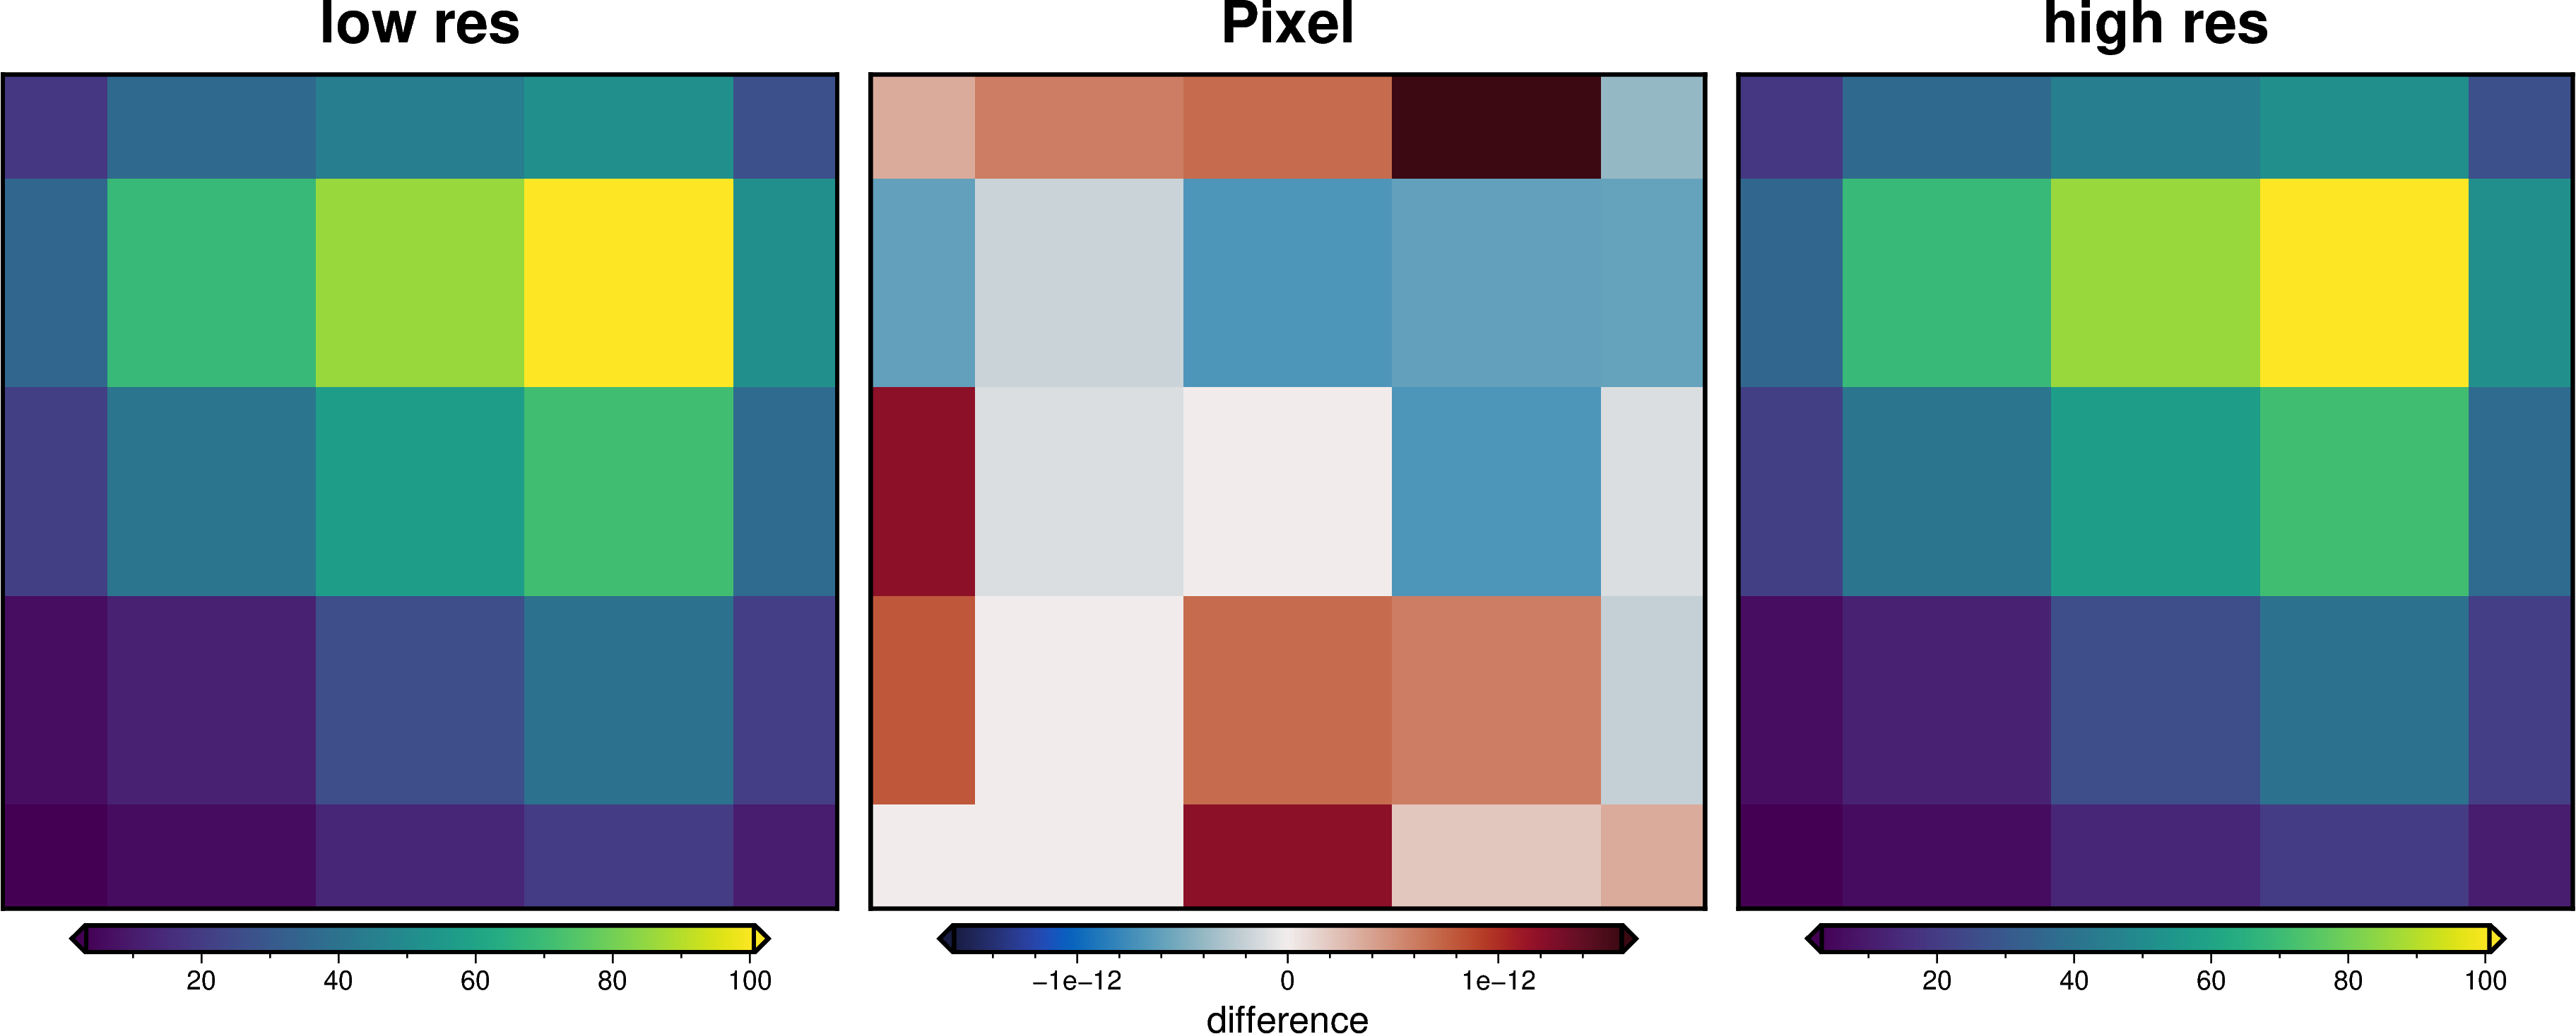

In [105]:
grids = utils.grd_compare(
    grav_grid_p, 
    grav_grid_p_highres, 
    plot=True,
    inset=False,
    grid1_name="low res",
    grid2_name="high res",
    title='Pixel',
    )